In [1]:
cd ~/dv/sns-chops/resolution/ARCS/PyChop/

/SNS/users/lj7/dv/sns-chops/resolution/ARCS/PyChop


In [2]:
import numpy as np, os, sys, glob
from matplotlib import pyplot as plt

In [3]:
%matplotlib notebook

Exp data

In [4]:
exp_E, exp_FWHM = np.load('./C4H2I2S-exp.npy')

mcvine data

In [5]:
mcvine_E, mcvine_FWHM = np.load('./mcvine-res-Ei_100.npy')

PyChop

In [6]:
sys.path.insert(0, "/SNS/users/lj7/dv")

In [7]:
from PyChop import PyChop2

In [59]:
def FWHM_pychop(
    x, 
    aperture_width=0.1751, S1=281., S2=79., B1=0.087, B2=0.4, Emod=172., 
    Ei = 100.,
    fc_pslit = 1.5,
    fc_choice='ARCS-100-1.5-SMI', fc_freq=600.):
    
    template = open('./arcs-opt-template.yaml').read()
    content = template.format(aperture_width=aperture_width)
    optyaml = 'arcs-opt.yaml'
    with open(optyaml, 'wt') as of:
        of.write(content)
    instrument = PyChop2(optyaml, fc_choice, fc_freq)
    instrument.ei = Ei
    instrument.moderator.mod_pars = [S1, S2, B1, B2, Emod]
    # print instrument.moderator.mod_pars

    fc = instrument.chopper_system.packages[fc_choice]
    fc.pslit = fc_pslit
    res = instrument.getResolution(x)
    return res

[281.0, 79.0, 0.087, 0.4, 172.0]


<IPython.core.display.Javascript object>


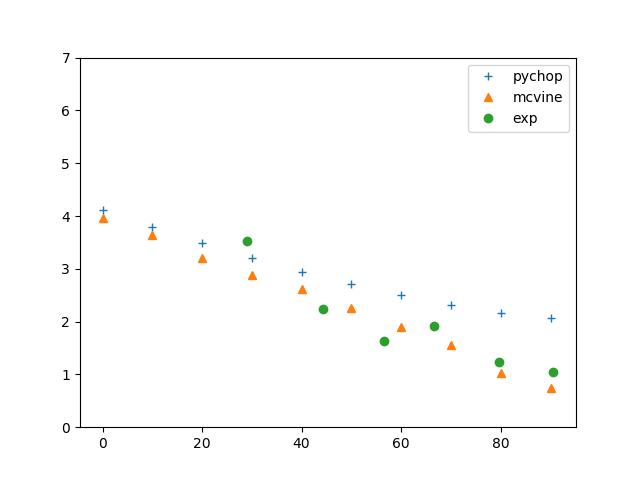

In [47]:
en = np.arange(0, 100, 10)
res = FWHM_pychop(en)
plt.figure()
plt.plot(en, res, '+', label='pychop')

positive = mcvine_E>=0
mcvine_E_positive = mcvine_E[positive]
mcvine_FWHM_positive = mcvine_FWHM[positive]
plt.plot(mcvine_E_positive, mcvine_FWHM_positive, '^', label='mcvine')
plt.plot(exp_E, exp_FWHM, 'o', label='exp')
plt.ylim(0, 7)
plt.legend()

In [60]:
import lmfit

In [61]:
model = lmfit.Model(FWHM_pychop)

In [62]:
params = model.make_params()

In [63]:
params

Parameters([('fc_pslit', <Parameter 'fc_pslit', 1.5, bounds=[-inf:inf]>),
            ('Ei', <Parameter 'Ei', 100.0, bounds=[-inf:inf]>),
            ('S2', <Parameter 'S2', 79.0, bounds=[-inf:inf]>),
            ('S1', <Parameter 'S1', 281.0, bounds=[-inf:inf]>),
            ('aperture_width',
             <Parameter 'aperture_width', 0.1751, bounds=[-inf:inf]>),
            ('B1', <Parameter 'B1', 0.087, bounds=[-inf:inf]>),
            ('B2', <Parameter 'B2', 0.4, bounds=[-inf:inf]>),
            ('Emod', <Parameter 'Emod', 172.0, bounds=[-inf:inf]>),
            ('fc_freq', <Parameter 'fc_freq', 600.0, bounds=[-inf:inf]>)])

In [64]:
model.set_param_hint('fc_pslit', min=1., max=5.)
model.set_param_hint('Ei', vary=False)
model.set_param_hint('fc_freq', vary=False)
model.set_param_hint('S1', min=100., max=600)
model.set_param_hint('S2', min=30., max=200)
model.set_param_hint('B1', min=0.01, max=0.2)
model.set_param_hint('B2', min=0.1, max=0.8)
model.set_param_hint('aperture_width', min=0.01, max=0.4)
model.set_param_hint('Emod', min=100, max=300.)

In [65]:
fitres = model.fit(data=mcvine_FWHM_positive, x=mcvine_E_positive)

<IPython.core.display.Javascript object>


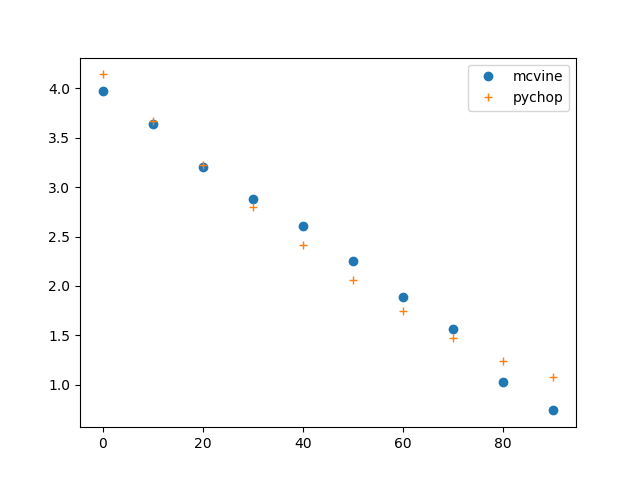

In [75]:
plt.figure()
plt.plot(mcvine_E_positive, mcvine_FWHM_positive, 'o', label='mcvine')
plt.plot(mcvine_E_positive, fitres.best_fit, '+', label='pychop')
plt.legend()

In [72]:
print fitres.fit_report()

[[Model]]
    Model(FWHM_pychop)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1674
    # data points      = 10
    # variables        = 7
    chi-square         = 0.29754847
    reduced chi-square = 0.09918282
    Akaike info crit   = -21.1476323
    Bayesian info crit = -19.0295366
[[Variables]]
    fc_pslit:        3.63098625 (init = 1.5)
    Ei:              100 (fixed)
    S2:              200.000000 (init = 79)
    S1:              600.000000 (init = 281)
    aperture_width:  0.01000086 (init = 0.1751)
    B1:              0.19999951 (init = 0.087)
    B2:              0.40000000 (init = 0.4)
    Emod:            100.000000 (init = 172)
    fc_freq:         600 (fixed)



The fit does not make much sense it seems
Maybe it is better to fit the multiple Ei